# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

In [27]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1.Define the model class.

In [28]:

class MLP(nn.Module):
    def __init__(self, no_features, no_hidden=128, no_labels=1):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            nn.Linear(no_features, no_hidden),  # Input to first hidden layer
            nn.ReLU(),                          # ReLU activation
            nn.Dropout(0.2),                    # Dropout with probability 0.2

            nn.Linear(no_hidden, no_hidden),    # First hidden to second hidden layer
            nn.ReLU(),                          # ReLU activation
            nn.Dropout(0.2),                    # Dropout with probability 0.2

            nn.Linear(no_hidden, no_hidden),    # Second hidden to third hidden layer
            nn.ReLU(),                          # ReLU activation
            nn.Dropout(0.2),                    # Dropout with probability 0.2
            
            nn.Linear(no_hidden, no_labels),    # Third hidden to output layer
            nn.Sigmoid()                        # Sigmoid activation for binary classification
        )

    def forward(self, x):
        return self.mlp_stack(x)

#### Divide the dataset into a 80:20 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

2.Split the dataset and do preprocessing.

In [29]:
from common_utils import split_dataset, preprocess_dataset


# Define the preprocessing function
def preprocess(df, col_drop):
    # Columns to drop
    columns_to_drop = col_drop
    
    # Split the dataset (80% train, 20% test)
    X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.2, random_state=1)

    # Scale the features using StandardScaler
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
    
    return X_train_scaled, y_train, X_test_scaled, y_test

In [30]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Read the dataset
df = pd.read_csv('simplified.csv')

# Check if the 'filename' column exists
if 'filename' in df.columns:
    # Extract the label from the second-to-last part of the filename
    df['label'] = df['filename'].apply(lambda x: x.split('_')[-2] if isinstance(x, str) else None)
    
    # Drop rows with missing labels (optional, depending on your data)
    df = df.dropna(subset=['label'])
    
    # Convert labels to numerical values (optional, for machine learning)
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
    
    # Display label distribution
    print("Label distribution:\n", df['label'].value_counts())
else:
    print("The column 'filename' does not exist in the dataset.")


Label distribution:
 label
1    6202
0    5855
Name: count, dtype: int64


Since we are using scikit-learn's LabelEncoder, the labels will be automatically encoded in alphabetical order. Therefore:

- "neg" (n) will be encoded as 0
- "pos" (p) will be encoded as 1

#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **3**.

3.Define a Pytorch Dataset and Dataloaders.  

In [43]:
#check the first 10
df.head(10)

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,label
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803,0
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572,0
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824,0
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389,0
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966,0
5,app_3001_4001_phnd_neg_0005.wav,135.999178,526,75.142857,0.497188,0.090823,0.471613,0.074965,0.260926,0.015251,...,53.083332,0.890096,58.104053,-5.507715,58.004536,-4.187471,57.342594,-3.229783,58.444675,0
6,app_3001_4001_phnd_neg_0006.wav,172.265625,14011,400.314286,0.634231,0.057083,0.588160,0.049847,0.273873,0.008327,...,49.157066,1.565232,47.803371,0.034003,49.174339,-3.929676,40.407154,0.458018,44.044567,0
7,app_3001_4001_phnd_neg_0007.wav,161.499023,17465,371.595745,0.636416,0.055022,0.614860,0.045458,0.273905,0.008309,...,47.107910,2.236927,47.174232,-0.198456,47.003994,-3.074307,44.398785,1.496647,45.236771,0
8,app_3001_4001_phnd_neg_0008.wav,103.359375,1301,130.100000,0.500891,0.093328,0.443942,0.081705,0.247834,0.021912,...,53.223858,0.089832,53.650665,-1.553041,64.733162,-4.046652,47.502098,-0.712033,52.464554,0
9,app_3001_4001_phnd_neg_0009.wav,151.999081,18919,402.531915,0.646325,0.053628,0.559063,0.048229,0.272631,0.009005,...,39.441525,2.494456,47.822319,-0.930074,49.263699,-4.808851,42.561642,0.538988,43.176216,0


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12057 entries, 0 to 12056
Data columns (total 79 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   filename             12057 non-null  object 
 1   tempo                12057 non-null  float64
 2   total_beats          12057 non-null  int64  
 3   average_beats        12057 non-null  float64
 4   chroma_stft_mean     12057 non-null  float64
 5   chroma_stft_var      12057 non-null  float64
 6   chroma_cq_mean       12057 non-null  float64
 7   chroma_cq_var        12057 non-null  float64
 8   chroma_cens_mean     12057 non-null  float64
 9   chroma_cens_var      12057 non-null  float64
 10  melspectrogram_mean  12057 non-null  float64
 11  melspectrogram_var   12057 non-null  float64
 12  mfcc_mean            12057 non-null  float64
 13  mfcc_var             12057 non-null  float64
 14  mfcc_delta_mean      12057 non-null  float64
 15  mfcc_delta_var       12057 non-null 

In [45]:
# Drop filename & Label
col_drop = ["filename", "label"]

# Preprocess the dataset via splitting and also scaling 
X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df, col_drop= col_drop)

In [34]:
# Define the Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (ndarray): The input features (e.g., X_train_scaled or X_test_scaled).
            y (ndarray): The labels (e.g., y_train or y_test).
        """
        self.X = torch.tensor(X, dtype=torch.float32)  # Convert input features to PyTorch tensors
        self.y = torch.tensor(y, dtype=torch.long)     # Convert labels to PyTorch tensors (long for classification)

    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.X)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to fetch.
        Returns:
            Tuple of (input features, label) for the given index.
        """
        return self.X[idx], self.y[idx]

# Initialize the DataLoaders
def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test, batch_size):
    """
    Args:
        X_train_scaled (ndarray): Scaled input features for training.
        y_train (ndarray): Training labels.
        X_test_scaled (ndarray): Scaled input features for testing.
        y_test (ndarray): Test labels.
        batch_size (int): Batch size for loading the data.

    Returns:
        train_dataloader (DataLoader): Dataloader for the training set.
        test_dataloader (DataLoader): Dataloader for the test set.
    """
    # Create instances of the CustomDataset for training and testing
    train_dataset = CustomDataset(X_train_scaled, y_train)
    test_dataset = CustomDataset(X_test_scaled, y_test)

    # Create DataLoaders for training and testing
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader


4.Next, define the model, optimizer and loss function.

In [35]:
import torch.optim as optim  
from common_utils import EarlyStopper

# Define the parameters for the input_size, hidden_size and output_size

input_size = X_train_scaled.shape[1]  # Number of input features
hidden_size = 128  # Hidden layer size
output_size = 1  # Binary classification (1 output neuron)
learning_rate = 0.001


In [36]:
# Define the model
model = MLP(input_size, hidden_size, output_size)

# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# Binary Cross Entropy Loss for binary classification
loss_fn = nn.BCELoss()

# Initialize EarlyStopper with patience and min_delta
early_stopper = EarlyStopper(patience=3, min_delta=0)  

5.Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [40]:
# Training loop with early stopping using the EarlyStopper class
def train_model(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_idx, (data, labels) in enumerate(train_dataloader):
            data, labels = data.to(device), labels.to(device).float()  # Ensure labels are float for BCELoss

            # Forward pass
            outputs = model(data).squeeze()
            loss = loss_fn(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate accuracy on the training batch
            predicted = (outputs > 0.5).float()  # Predictions thresholded at 0.5
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss /= len(train_dataloader)
        train_accuracy = correct_train / total_train

        # Store train loss and accuracy
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validate the model
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data, labels in test_dataloader:
                data, labels = data.to(device), labels.to(device).float()

                outputs = model(data).squeeze()
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy on the validation batch
                predicted = (outputs > 0.5).float()  # Predictions thresholded at 0.5
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(test_dataloader)
        val_accuracy = correct_val / total_val

        # Store validation loss and accuracy
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

        # Check if early stopping is triggered
        if early_stopper.early_stop(val_loss):
            print(f'Early stopping at epoch {epoch+1}')
            break

    return train_losses, val_losses, train_accuracies, val_accuracies


In [41]:
# Preparing the train_dataloader and test_dataloader
train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test, batch_size=128)

# Training the model and getting the results
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_dataloader, test_dataloader, optimizer, loss_fn)

Epoch 1/100 - Train Loss: 0.6854, Val Loss: 0.6766, Train Acc: 0.5436, Val Acc: 0.5730
Epoch 2/100 - Train Loss: 0.6638, Val Loss: 0.6596, Train Acc: 0.6009, Val Acc: 0.6012
Epoch 3/100 - Train Loss: 0.6468, Val Loss: 0.6411, Train Acc: 0.6232, Val Acc: 0.6418
Epoch 4/100 - Train Loss: 0.6306, Val Loss: 0.6338, Train Acc: 0.6434, Val Acc: 0.6410
Epoch 5/100 - Train Loss: 0.6139, Val Loss: 0.6188, Train Acc: 0.6580, Val Acc: 0.6642
Epoch 6/100 - Train Loss: 0.5957, Val Loss: 0.6017, Train Acc: 0.6734, Val Acc: 0.6824
Epoch 7/100 - Train Loss: 0.5784, Val Loss: 0.5962, Train Acc: 0.6946, Val Acc: 0.6820
Epoch 8/100 - Train Loss: 0.5632, Val Loss: 0.5881, Train Acc: 0.7045, Val Acc: 0.6911
Epoch 9/100 - Train Loss: 0.5458, Val Loss: 0.5753, Train Acc: 0.7191, Val Acc: 0.7023
Epoch 10/100 - Train Loss: 0.5295, Val Loss: 0.5643, Train Acc: 0.7291, Val Acc: 0.7131
Epoch 11/100 - Train Loss: 0.5158, Val Loss: 0.5600, Train Acc: 0.7408, Val Acc: 0.7114
Epoch 12/100 - Train Loss: 0.5054, Val Lo

#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


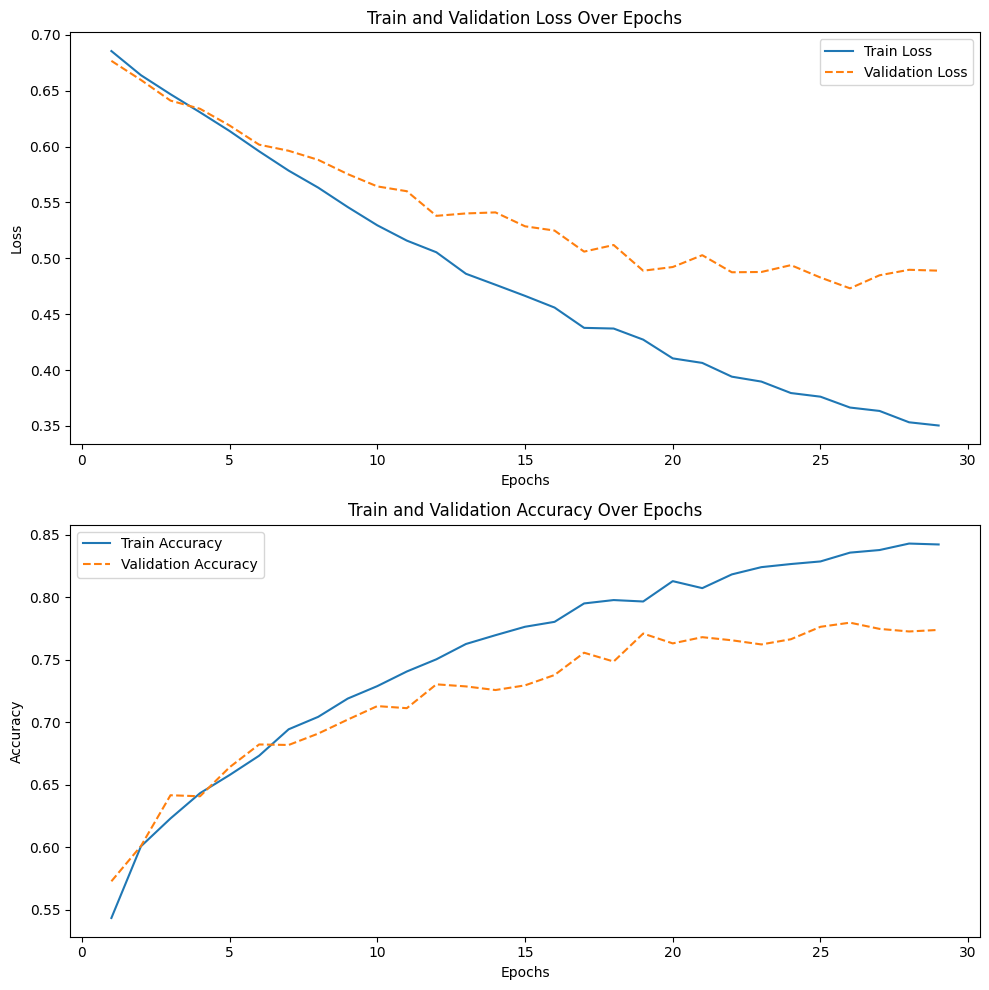

In [42]:
# Plot the losses and accuracies
epochs = len(train_losses)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot 1: Train and Validation Loss
axs[0].plot(range(1, epochs + 1), train_losses, label="Train Loss")
axs[0].plot(range(1, epochs + 1), val_losses, label="Validation Loss", linestyle='--')
axs[0].set_title('Train and Validation Loss Over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot 2: Train and Validation Accuracy
axs[1].plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy")
axs[1].plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy", linestyle='--')
axs[1].set_title('Train and Validation Accuracy Over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()


6.Comment on line plots.

In [ ]:
# YOUR CODE HERE
answer = ""

### Comment 

#### Train and Validation Loss

- The training loss is consistently decreasing over the epochs, indicating that the model is learning effectively from the training data and minimizing the loss function. This downward trend also suggests that the optimizer is effectively updating the weights to reduce the error on the training set.
  
- The validation loss is also decreasing, though at a slower rate. This indicates that the model is generalizing well and is not overfitting, given that the gap between the training and validation losses remains relatively small.

- Towards the end of the training, around the 18th epoch, the validation loss begins to flatten while the training loss continues to decrease. This could be an early sign that the model might start to overfit if training continues, as it improves on the training data without similar improvement on the validation data.

#### Train and Validation Accuracy

- The training accuracy is consistently improving over each epoch, suggesting that the model is effectively learning the patterns in the training data. The smooth upward trend reflects that the optimizer is working well to minimize the error and increase accuracy on the training set.

- The validation accuracy follows a similar trend, steadily increasing, though at a slower pace. This is consistent with the behavior of the validation loss, where improvements gradually slow down as training progresses.

- The gap between the training and validation accuracy remains relatively small, which is a positive sign, as it indicates that the model is not overfitting by too much and is likely to generalize well to unseen data.

#### Conclusion

- Overall, the model appears to be well-trained and capable of generalizing the task, as demonstrated by the relatively similar performance between the validation set and the training set. The implementation of early stopping is critical here, as it helps prevent overfitting by halting training when the validation loss plateaus. This mechanism effectively ensures that the model retains its ability to perform well on unseen data without becoming overly specialized to the training set.

### Code Analysis

- The training loop leverages PyTorch’s `DataLoader`, which efficiently handles batching and shuffling of the data, helping to optimize memory usage during training. This is particularly important when working with larger datasets.

- By utilizing `torch.no_grad()` within the validation loop, the code avoids unnecessary gradient computations, making the validation phase both computationally efficient and memory-saving.

- The code tracks both training and validation losses as well as accuracies, providing a comprehensive view of the model's progress. This allows for a balanced evaluation of its performance across epochs and helps in identifying when the model might begin to overfit.

- Early stopping is implemented through an `EarlyStopper` class, which checks the validation loss after each epoch. If no improvement is observed over a specified patience period, the training process is halted. This setup prevents the model from overfitting and ensures that it does not undergo unnecessary computations after it has reached its optimal state.

- The choice of the Adam optimizer with a learning rate of 0.001, combined with a batch size of 128, provides an effective balance between convergence speed and stability. Additionally, the use of binary cross-entropy as the loss function is suitable for binary classification tasks, ensuring that the model's outputs are optimized for this specific problem.